In [1]:
ls

Aggregation.txt              overlap.txt19frames.gif
Aggregation.txt12frames.gif  overlap.txt2frames.gif
Aggregation.txt20frames.gif  overlap.txt5frames.gif
Aggregation.txt22frames.gif  overlap.txt6frames.gif
Aggregation.txt3frames.gif   pogo.ipynb
animation-400.mp4            R15.txt
animation-b.mp4              R15.txt22frames.gif
animation-c.mp4              R15.txt40frames.gif
animation-d.mp4              R15.txt50frames.gif
animation.gif                R15.txt60frames.gif
animation.mp4                R15.txt80frames.gif
Compound.txt                 R15.txt93frames.gif
Compound.txt22frames.gif     README.md
D31.txt                      scikitlearn-clustering-data.ipynb
D31.txt19frames.gif          spiral20frames.mp4
D31.txt22frames.gif          spiral40frames.mp4
jain40frames.mp4             spiral.txt
jain.txt                     spiral.txt20frames.gif
jain.txt20frames.gif         spiral.txt5frames.gif


In [2]:
import numpy as np
import pandas as pd
import gudhi

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [4]:

from sklearn import datasets

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import os.path

In [5]:
from urllib.request import urlopen
from urllib.parse import urlparse

In [6]:
%matplotlib inline

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [7]:

urls_with_ground_truth = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/a1.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt']

urls_without_ground_truth = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/overlap.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/a1.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt']

ground_truth_urls = ['https://cs.joensuu.fi/sipu/datasets/overlap.pa'
    
]

urls_with_ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in urls_with_ground_truth
}


urls_without_ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in urls_without_ground_truth
}


ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in ground_truth_urls
}

In [8]:
urls_with_ground_truth

{'D31.txt': 'https://cs.joensuu.fi/sipu/datasets/D31.txt',
 'spiral.txt': 'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
 'pathbased.txt': 'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
 'a1.txt': 'https://cs.joensuu.fi/sipu/datasets/a1.txt',
 'R15.txt': 'https://cs.joensuu.fi/sipu/datasets/R15.txt'}

In [9]:
ground_truth

{'overlap.pa': 'https://cs.joensuu.fi/sipu/datasets/overlap.pa'}

In [10]:
#select file here
filename = 'overlap.txt'
filename in urls_with_ground_truth

False

In [11]:
if filename in urls_with_ground_truth:
    url= urls_with_ground_truth[filename]
    print(url)
    parse = urlparse(url)
    print(filename)
    raw_data = urlopen(url)
    data = np.loadtxt(raw_data)

    print(data.shape)
    print(data[:10])

    y = data[:,2]
    print(y.shape)
    X = data[:,:2]
    print(X.shape)

else:
    pass

In [12]:
#iris = load_iris()
#X = iris.data
#y = iris.target

In [13]:
#data from scikitlearn tutorial on clustering 

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), np.ones(n_samples,dtype='int')

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

In [14]:
X=no_structure[0]
y=no_structure[1]

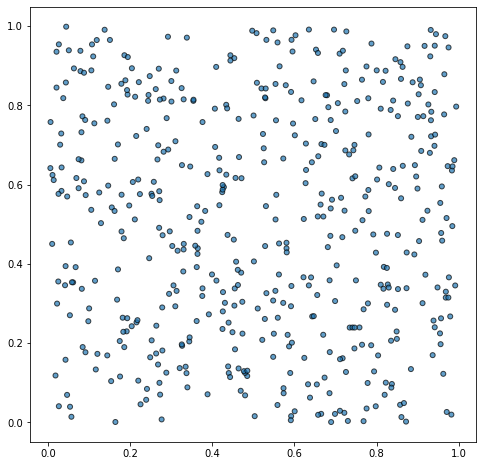

In [15]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [16]:
rips_complex = gudhi.RipsComplex(points=X)

In [17]:
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
   
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())

500 vertices
125250 simplices
dimension: 1


usetex mode requires TeX.


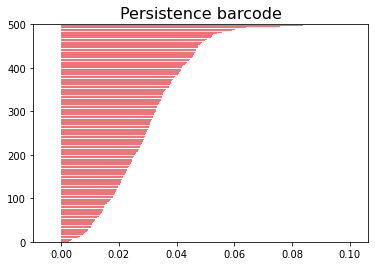

In [18]:
diag = simplex_tree.persistence()
gudhi.plot_persistence_barcode(diag)
plt.show()

In [19]:
#move through list and assign clusters to conected components
point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0
cluster_dict_list = []
distance_list = []
for simplex in simplex_tree.get_filtration():
    if len(simplex[0])>1:
        if all(value > 0 for value in list(point_dict.values())):
            if len(np.unique(np.array(list(point_dict.values())))) == 1:
                print('break')
                print(simplex)
                print(simplex[1])
                simplex_tree.prune_above_filtration(simplex[1])
                break


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] == 0:
            counter += 1
            point_dict[simplex[0][0]] = counter
            point_dict[simplex[0][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] != 0:
            point_dict[simplex[0][0]] = point_dict[simplex[0][1]]

            #and vice versa
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] == 0:
            point_dict[simplex[0][1]] = point_dict[simplex[0][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] != 0 and point_dict[simplex[0][0]] != point_dict[simplex[0][1]]:
            larger_cluster_number = max(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            smaller_cluster_number = min(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
                    
        distance_list.append(simplex[1])
        cluster_dict_list.append(point_dict.copy())

break
([117, 138], 0.09662111635050497)
0.09662111635050497


In [20]:
max(distance_list)

0.09659698100736341

In [21]:
len(distance_list)

3330

In [22]:
distance_array = np.array(distance_list)
print(len(distance_array))
distance_array.dtype

3330


dtype('float64')

In [23]:
length = len(cluster_dict_list)
length

3330

In [24]:
print(simplex_tree.num_simplices(), 'simplices')
#?

3831 simplices


In [25]:
#check that all clusters have merged
len(np.unique(np.array(list(point_dict.values()))))

1

In [26]:
print(cluster_dict_list[-2].values()) #penultimate clustering has 2 clusters
print(cluster_dict_list[-1].values()) #last clustering finally merges to all one cluster

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [27]:
#find the gaps between birth/death pairs
gaps = np.diff(distance_array)
gaps.shape

(3329,)

In [28]:
#add a zero back to the beginning of the gaps
gaps = np.concatenate([np.zeros(1),gaps])

In [29]:
#find normalized distance
scaler = MinMaxScaler()
normed_distance = scaler.fit_transform(distance_array.reshape(-1,1)).T.reshape(length)

In [30]:
#then invert them and multiply by the gaps to weight early connections in the filtration
inverted_normed_distance = 1 - normed_distance
inverted_normed_distance

array([1.00000000e+00, 9.94033038e-01, 9.93468563e-01, ...,
       6.66673685e-04, 6.75650732e-05, 0.00000000e+00])

In [31]:
normed_gaps = np.multiply(gaps, inverted_normed_distance)
normed_gaps

array([0.00000000e+00, 5.59204889e-04, 5.28707114e-05, ...,
       2.27144716e-08, 3.81631890e-09, 0.00000000e+00])

In [32]:
#normalize to create a probability vector
gap_vector = normed_gaps / np.sum(normed_gaps)

In [33]:
#check
np.sum(gap_vector)

1.0000000000000002

In [34]:
gap_vector

array([0.00000000e+00, 1.18765195e-02, 1.12288009e-03, ...,
       4.82415068e-07, 8.10518411e-08, 0.00000000e+00])

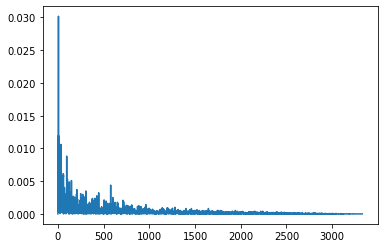

In [35]:
plt.plot(gap_vector)

In [36]:
marker = 0
for i in range(1,length-1):
    if cluster_dict_list[marker] == cluster_dict_list[i]:

        gap_vector[marker] += gap_vector[i]
        gap_vector[i] = 0
        #print(marker)


    else:
        marker = i

1.0000000000000002


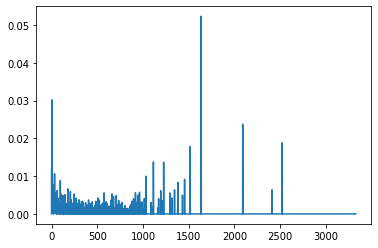

In [37]:
print(np.sum(gap_vector))
plt.plot(gap_vector)

In [38]:
candidates = np.flip(np.argsort(gap_vector))

In [39]:
gap_vector[candidates[0]]

0.05231084613424534

In [40]:
idx = candidates[0]
idx

1636

In [41]:
pred = np.array(list(cluster_dict_list[idx].values()))

In [42]:
print(gap_vector[idx])
print('percent confidence')
'{:.1%}'.format(gap_vector[idx])

0.05231084613424534
percent confidence


'5.2%'

In [43]:
np.array(list(cluster_dict_list[idx].values()))

array([ 42,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   0,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,  42,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1, 158,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

In [44]:
#cluster_idx_array = (np.unique(np.array(list(cluster_dict_list[idx].values()))))
#print(cluster_idx_array)
#print(np.count_nonzero(cluster_idx_array))

number_of_clusters = np.count_nonzero(np.unique(np.array(list(cluster_dict_list[idx].values()))))
print(number_of_clusters)
print('your dataset appears to have', number_of_clusters,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

4
your dataset appears to have 4 clusters, not including any outliers


In [45]:
true = y

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

0.0
-0.5229337999043899


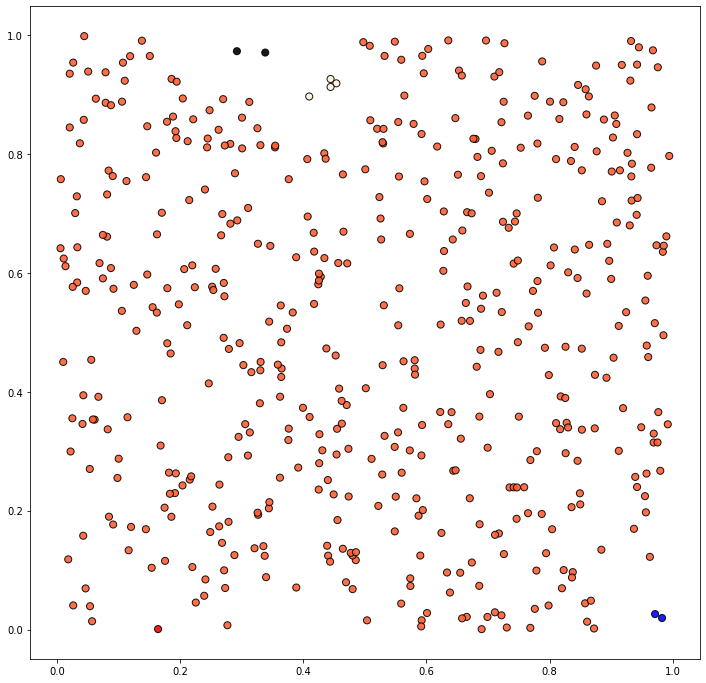

In [46]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='flag',
            norm=None,
            alpha=.9,
            edgecolor="k")

In [47]:
idx_list = candidates[:5]
idx_list

array([1636,    6, 2091, 2523, 1516])

In [48]:
idx_list.sort()

In [49]:
idx_list = [x for x in idx_list if x < idx]

In [50]:
idx_array = np.asarray(idx_list)
idx_array

array([   6, 1516])

In [51]:
silhouette_list = []
for i in idx_list:
    silhouette = metrics.silhouette_score(X, np.array(list(cluster_dict_list[i].values())), metric="euclidean")
    silhouette_list.append(silhouette)

In [52]:
silhouette_array = np.asarray(silhouette_list)

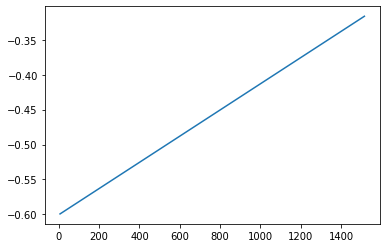

In [53]:
plt.plot(idx_array,silhouette_array)

In [54]:
max(silhouette_array)

-0.3162407726936235

In [55]:
max_idx = silhouette_array.argmax()

In [56]:
idx = idx_array[max_idx]
idx

1516

In [57]:
#idx = silhouette_scores.index(max(silhouette_scores[simplex_tree.num_vertices():idx]))
#print(idx)

In [58]:
rand_score_list = []
true = y
for i in idx_list:
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [59]:
rand_score_array = np.asarray(rand_score_list)

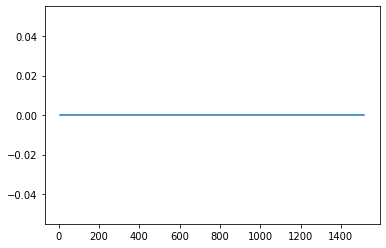

In [60]:
 plt.plot(idx_array,rand_score_array)

In [61]:
max(rand_score_array)

0.0

In [62]:
best_idx = idx_array[rand_score_array.argmax()]
best_idx

6

In [63]:
pred = np.array(list(cluster_dict_list[idx].values()))
pred

array([ 42,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   0,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,
         1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   2,  42,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1, 158,   1,   1,   1,   1,   1,   1,
         1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

In [64]:
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

0.0

In [65]:
masked = np.ma.masked_where(pred == 0,pred)
masked

masked_array(data=[42, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, --, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
                   1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 42, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 158, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 42, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 2, 1, 2, 1, 1,

In [66]:
#cluster_idx_array = (np.unique(np.array(list(cluster_dict_list[idx].values()))))
#print(cluster_idx_array)
#print(np.count_nonzero(cluster_idx_array))

number_of_clusters = np.count_nonzero(np.unique(np.array(list(cluster_dict_list[idx].values()))))
print(number_of_clusters)
print('your dataset appears to have', number_of_clusters,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

5
your dataset appears to have 5 clusters, not including any outliers


In [67]:
cmap = plt.cm.get_cmap("flag").copy()
cmap.set_bad(cmap(0))
cmap.set_under(cmap(1))

In [68]:
cmap.get_bad()

array([1., 0., 0., 1.])

In [69]:
#cmap(number_of_clusters)

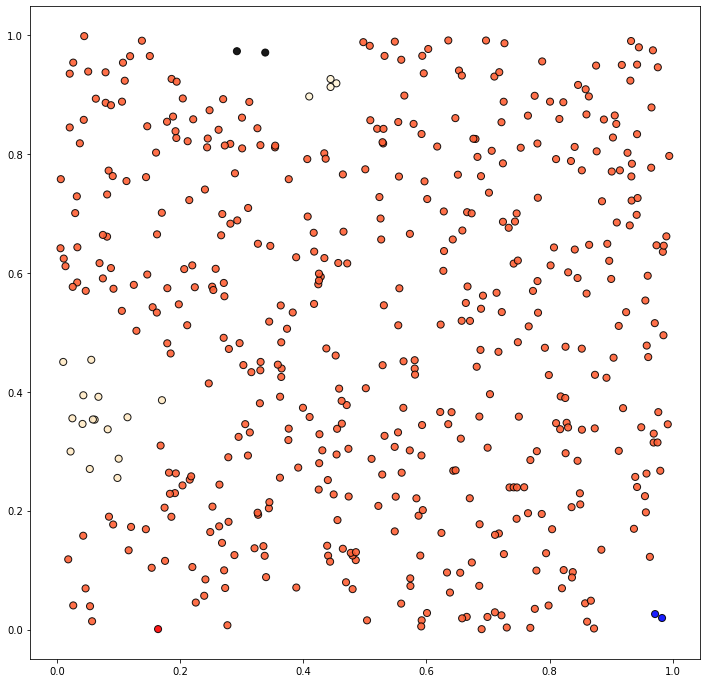

In [70]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

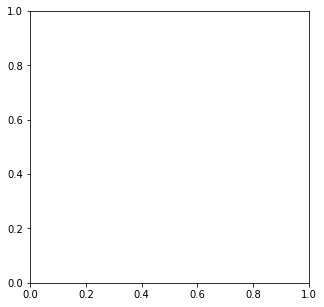

In [71]:
fig, ax = plt.subplots(figsize=(5,5))
frames = len(idx_array)


outfile = filename + str(frames) + 'frames.gif'

if not os.path.isfile(outfile):
    def init():
        scatter = ax.scatter(X[:, 0], X[:, 1],
                        s=40, 
                        c=np.array(list(cluster_dict_list[0].values())),
                        marker="o",
                        cmap=cmap,
                        norm=None,
                        alpha=1,
                        edgecolor="k")
        #ax.set(xlim=(-1, 35), ylim=(-1, 35))

        return scatter,

    #collection = PatchCollection(X, animated=True)

    #ax.add_collection(collection)
    #ax.autoscale_view(True)

    def animate(i):

        scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=40, 
                    c=np.array(list(cluster_dict_list[idx_array[i]].values())),
                    marker="o",
                    cmap=cmap,
                    norm=None,
                    alpha=1,
                    edgecolor="k")
        return scatter,



    ani = FuncAnimation(fig, animate,interval=100,init_func=init,frames=frames,repeat=False, blit=True)

    #ani.save('animation.gif')



    #writer=animation.PillowWriter()

    #writer = animation.FFMpegWriter(fps=2,bitrate=1000)

    ani.save(outfile, dpi=200)
    fig.show()


def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


cluster_dict_list, candidates, idx = pogo(X)

true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))
